<a href="https://colab.research.google.com/github/jw-jin/2021-DAP/blob/main/RiotAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Crawled Dataset**
Riot API를 통해 매치데이터를 수집하여 진행하였습니다.<br>
colab은 하루 12시간의 사용 제한시간이 있고 비활성시 연결이 해제되기 때문에,<br>
로컬 환경에서 파이썬을 이용해 데이터를 수집하였습니다.(riot_crawling.py)<br>





# **Settings**
로컬에서 수집한 데이터 파일을 colab에서 이용하기 위하여 <br>
구글 드라이브에 업로드 한 후, 이를 불러와 사용하였습니다. <br>

In [34]:
from google.colab import drive # 구글 드라이브에서 파일 불러오기
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
#라이브러리 임포트
import pandas as pd
import requests, json
import dash
from dash import html
import plotly.graph_objects as go
from dash import dcc, no_update
import plotly.express as px
from dash.dependencies import Input, Output
from jupyter_dash import JupyterDash

from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn import tree
from IPython.display import Image
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np


In [36]:
# 드라이브 경로 설정
ch_data_path = '/content/drive/MyDrive/ch_matchdata.csv' # 챌린저 매치데이터 파일 경로
gm_data_path = '/content/drive/MyDrive/gm_matchdata.csv' # 그랜드마스터 매치데이터 파일 경로
m_data_path = '/content/drive/MyDrive/m_matchdata.csv' # 마스터 매치데이터 파일 경로

match_loser_path = '/content/drive/MyDrive/match_loser_data.csv'
match_winner_path = '/content/drive/MyDrive/match_winner_data.csv'
new_data_path = '/content/drive/MyDrive/new_match.csv'

# csv 불러오기
win_data = pd.read_csv(match_loser_path)
lose_data = pd.read_csv(match_winner_path)
plus_data = pd.read_csv(new_data_path)
ch_data = pd.read_csv(ch_data_path, encoding= 'cp949')
gm_data = pd.read_csv(gm_data_path, encoding= 'cp949')
m_data = pd.read_csv(m_data_path, encoding= 'cp949')

In [18]:
ch_data.head()

,gameId,summonerName,win,individualPosition,championId,championName,champLevel,kills,deaths,assists,item0,item1,item2,item3,item4,item5,item6,goldEarned,dragonKills,baronKills,objectivesStolen,teamId,totalDamageDealtToChampions,turretKills
0,5587213272,Kingen,True,TOP,157,Yasuo,17,6,8,14,3006,2055,6673,3031,3033,6333,3363,15877,0,0,0,100,21956,5
1,5587213272,zhongjuzhizhan,True,JUNGLE,421,RekSai,18,17,8,11,6693,3036,3026,3047,3814,6695,3364,18565,1,1,0,100,32553,3
2,5587213272,유백진,True,MIDDLE,4,TwistedFate,16,10,10,13,3145,6656,3020,3157,3100,3094,3340,14928,0,0,0,100,29395,0
3,5587213272,hope3,True,BOTTOM,222,Jinx,17,10,8,13,6671,1038,2421,3031,3046,3006,3363,15287,1,0,0,100,23537,1
4,5587213272,장임박,True,UTILITY,412,Thresh,15,1,4,25,3857,3190,0,3109,3117,3067,3364,9518,1,0,0,100,9165,0


# **Preprocessing**


티어 별 챔피언간 승률을 정리

In [21]:
# 챌린저 티어 승률
pd.set_option('display.max_row', 100)
c_df = ch_data

# 챔피언별 승률 
champion_df = c_df.loc[:,['championId', 'championName']]

champion_df = champion_df.drop_duplicates() # 중복제거
champion_df = champion_df.sort_values('championId') # championid 순 정렬

id_list = champion_df['championId'].tolist()
id_dict = champion_df.set_index('championId').T.to_dict('list')
ch_win_df = pd.DataFrame(columns=['championId','championName', 'winrate', 'loserate'])


for key,value in id_dict.items(): # key = id value = name
  if(key < 888): #결측값 처리 (최대 키값은 887)
    tmp_df = c_df[c_df['championId'] == key] 
    win_count = tmp_df['win'].value_counts(normalize=True)
    data = {
        'championId' : key,
        'championName' : value[0],
        'winrate' : win_count[1] * 100,
        'loserate' : win_count[0] * 100
    }
    ch_win_df = ch_win_df.append(data,ignore_index=True)
ch_win_df.head()


,championId,championName,winrate,loserate
0,1,Annie,40.540541,59.459459
1,2,Olaf,54.480287,45.519713
2,3,Galio,50.235726,49.764274
3,4,TwistedFate,50.551471,49.448529
4,5,XinZhao,52.397498,47.602502


In [22]:
# 그랜드마스터 티어 승률
gm_df = gm_data

champion_df = gm_df.loc[:,['championId', 'championName']]
champion_df = champion_df.drop_duplicates() # 중복제거
champion_df = champion_df.sort_values('championId') # championid 순 정렬

id_list = champion_df['championId'].tolist()
id_dict = champion_df.set_index('championId').T.to_dict('list')
gm_win_df = pd.DataFrame(columns=['championId','championName', 'winrate', 'loserate'])

for key,value in id_dict.items(): # key = id value = name
  if(key < 888): #결측값 처리
    tmp_df = gm_df[gm_df['championId'] == key] 
    win_count = tmp_df['win'].value_counts(normalize=True)
    data = {
        'championId' : key,
        'championName' : value[0],
        'winrate' : win_count[1] * 100,
        'loserate' : win_count[0] * 100 
    }
    gm_win_df = gm_win_df.append(data,ignore_index=True)
gm_win_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  if __name__ == '__main__':


,championId,championName,winrate,loserate
0,1,Annie,49.714286,50.285714
1,2,Olaf,49.038462,50.961538
2,3,Galio,52.470187,47.529813
3,4,TwistedFate,50.474183,49.525817
4,5,XinZhao,50.795756,49.204244


In [23]:
# 마스터 티어 승률
m_df = m_data

champion_df = m_df.loc[:,['championId', 'championName']]
champion_df = champion_df.drop_duplicates() # 중복제거
champion_df = champion_df.sort_values('championId') # championid 순 정렬

id_list = champion_df['championId'].tolist()
id_dict = champion_df.set_index('championId').T.to_dict('list')
m_win_df = pd.DataFrame(columns=['championId','championName', 'winrate', 'loserate'])

for key,value in id_dict.items(): # key = id value = name
  if(key < 888): #결측값 처리
    tmp_df = m_df[m_df['championId'] == key] 
    win_count = tmp_df['win'].value_counts(normalize=True)
    data = {
        'championId' : key,
        'championName' : value[0],
        'winrate' : win_count[1] * 100,
        'loserate' : win_count[0] * 100
    }
    m_win_df = m_win_df.append(data,ignore_index=True)

m_win_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  if __name__ == '__main__':


,championId,championName,winrate,loserate
0,1,Annie,51.931716,48.068284
1,2,Olaf,48.578313,51.421687
2,3,Galio,52.124183,47.875817
3,4,TwistedFate,49.681529,50.318471
4,5,XinZhao,50.522228,49.477772


# Old

In [ ]:
# 평균 골드를 이용한 결측값 처리 아이디어
# 실행시간이 너무 오래걸림

# want_df = ch_data

# want_df['avrgold'] = 0


# for game_id in want_df['gameId']:
#   match_index = want_df.index[want_df['gameId'] == game_id].tolist() 
#   for i in range(len(match_index)):
#     a = want_df.loc[match_index[i]] # 해당 인덱스의 게임 정보
#     if(a['avrgold'] != 0): # 이미 평균 골드를 구했으면 continue
#       continue
#     if(a['individualPosition'] != 'UTILITY'): #서포터가 아닌경우
#       tmp_df2 = want_df[want_df['gameId'] == a['gameId']] # gameID가 같은 경우
#       tmp_df2 = tmp_df2[tmp_df2['teamId'] == a['teamId']] # 같은 팀인 경우    
#       utility_index = tmp_df2[tmp_df2['individualPosition'] == 'UTILITY'].index
#       tmp_df2 = tmp_df2.drop(utility_index)
      
#       avr = tmp_df2['goldEarned'].mean()
    
#       want_df.at[i,'avrgold'] = avr
#     elif(a['individualPosition'] == 'UTILITY'): #서포터인 경우
#       tmp_df2 = want_df[want_df['gameId'] == a['gameId']] # gameID가 같은 경우
#       tmp_df2 = tmp_df2[tmp_df2['individualPosition'] == a['individualPosition']] # 같은 라인인 경우 
#       util_index = tmp_df2.index
#       if len(util_index) == 2:
#         want_df.at[util_index[0],'avrgold'] = want_df.loc[util_index[1],'goldEarned'] # 서포터 끼리 서로의 골드 획득량 넣기
#         want_df.at[util_index[1],'avrgold'] = want_df.loc[util_index[0],'goldEarned']

# want_df['golddiff'] =  want_df['avrgold'] - want_df['goldEarned']
# want_df = want_df[['gameId', 'summonerName', 'win', 'individualPosition', 'championId',
#        'championName', 'champLevel', 'kills', 'deaths', 'assists', 'item0',
#        'item1', 'item2', 'item3', 'item4', 'item5', 'item6', 'goldEarned', 'avrgold', 'golddiff',
#        'dragonKills', 'baronKills', 'objectivesStolen', 'teamId',
#        'totalDamageDealtToChampions', 'turretKills']]
# want_df

# **Data Visualization**
Dash를 이용하여 챔피언 별 승률과 챔피언 별 상대 승률과 을 시각화

In [24]:
# install packages
!pip install dash
!pip install jupyter_dash

json을 이용하여 아이템 정보 파싱

In [25]:
url = requests.get("http://ddragon.leagueoflegends.com/cdn/11.24.1/data/ko_KR/item.json")
item_json = url.text
item_info = json.loads(item_json) 

챔피언 별 상대 승률을 구해 데이터프레임으로 반환하는 함수

In [26]:
# 챔피언별 상대 승률
def get_opp_winrate(champ_name,want_df):

  match_index = want_df.index[want_df['championName'] == champ_name].tolist() # key 챔피언 id로 고르기
  for i in range(len(match_index)):
    a = want_df.loc[match_index[i]] # 해당 인덱스의 게임 정보
    tmp_df2 = want_df[want_df['gameId'] == a['gameId']] # gameID가 같은경우
    tmp_df2 = tmp_df2[tmp_df2['individualPosition'] == a['individualPosition']] # 같은 라인인 경우 
    if(i==0):
      champ_opp_df = tmp_df2
    else:
      champ_opp_df = champ_opp_df.append(tmp_df2)


  champ_opp_df2 = champ_opp_df[champ_opp_df['championName'] != champ_name] # 내가 선택한 챔피언이 아닌 상대편의 정보만 
  opp_champ_id = pd.DataFrame(champ_opp_df2['championName'].value_counts()) # 상대했던 챔피언들 count
  opp_champ_id['win'] = 0
  opp_champ_id.rename(columns={'championName':'matchCount'},inplace=True)
  for i in range(len(champ_opp_df2)):
    tmp = champ_opp_df2.iloc[i]
    if(tmp['win'] == False):
      opp_champ_id.loc[tmp['championName'], 'win'] +=1

  

  opp_champ_id['winrate'] = (opp_champ_id['win'] / opp_champ_id['matchCount']) * 100

  for cnt, winrate, i in zip(opp_champ_id['matchCount'],opp_champ_id['winrate'],opp_champ_id.index):
    if(cnt<=5):
      opp_champ_id = opp_champ_id.drop([i]) # 5판 이하의 기록 drop
      continue
    elif(winrate == 100 or winrate == 0):
      opp_champ_id = opp_champ_id.drop([i]) # 상대 승률이 0퍼거나 100퍼인 경우의 기록 drop

  return opp_champ_id

챔피언별 사용 아이템 통계를 구해 데이터프레임으로 반환하는 함수

In [28]:
# 챔피언별 사용 아이템 통계
def get_itemlist(champ_name,want_df):

  match_index = want_df.index[want_df['championName'] == champ_name].tolist() # key 챔피언 id로 고르기
  for i in range(len(match_index)):
    a = want_df.loc[match_index[i]] # 해당 인덱스의 게임 정보
    tmp_df2 = want_df[want_df['gameId'] == a['gameId']] # gameID가 같은경우
    tmp_df2 = tmp_df2[tmp_df2['individualPosition'] == a['individualPosition']] # 같은 라인인 경우 
    if(i==0):
      champ_opp_df = tmp_df2
    else:
      champ_opp_df = champ_opp_df.append(tmp_df2)
 
  champ_my_df = champ_opp_df[champ_opp_df['championName'] == champ_name] # 내가 선택한 챔피언 정보만

  # 아이템 사용 횟수 
  item0_list = champ_my_df['item0'].tolist() 
  item1_list = champ_my_df['item1'].tolist()
  item2_list = champ_my_df['item2'].tolist()
  item3_list = champ_my_df['item3'].tolist()
  item4_list = champ_my_df['item4'].tolist()
  item5_list = champ_my_df['item5'].tolist()
  
  item_list = item0_list + item1_list + item2_list + item3_list + item4_list + item5_list 


  item_df = pd.DataFrame()

  item_df['count'] = item_list # count 열 추가
  item_df['item_name'] = 0 # item_name 열 추가

  item_df = item_df['count'].value_counts() # 아이템 사용횟수 카운트
  for code in item_df.index:
    delete_list = [0,2003,2010,2421,2423,2424,2055] # 빈 경우, 비스킷, 포션, 초시계,제어 와드 삭제
    for i in delete_list:
      if code == i :
        item_df = pd.DataFrame(item_df.drop([i]))

  for i,cnt in zip(item_df.index,item_df['count']):
    index = str(i)
    if cnt <= 5 : 
      item_df.drop([i])
      continue
    try:
      tmp = item_info['data'][index]['name']
    except:
      item_df.drop([i])
      continue
    item_df.at[i,'item_name'] = item_info['data'][index]['name']
    
  return item_df

Dash와 plotly를 이용한 시각화<br>
<br>
3개의 탭으로 나누어 각각 챔피언 별 승률, 챔피언 별 상대 승률, 챔피언 별 아이템 선택<br>
챔피언 별 승률은 티어와 정렬방식을 선택하여 원하는 티어의 승률을 확인할 수 있고, <br>
나머지 2개의 탭은 티어와 챔피언을 선택하여 선택한 챔피언과 상대 승률,<br>
선택한 챔피언이 사용한 아이템의 채택 횟수를 확인할 수 있다.

In [27]:
# Load Dash App
app = JupyterDash()

# Define App
# id_dict = 챔피언 ID, 이름 키 밸류로 들어있는 딕셔너리
name_list = list(id_dict.values())
id_list = list(id_dict.keys())
global result_df 
result_df = pd.DataFrame()

tgVar = ['Challenger', 'Grandmaster', 'Master']
winrate_op = ['default','High_winrate','Low_winrate']

# image

app.layout = html.Div([
    html.H1('League Of Legends Matchdata analyze'),
    dcc.Tabs(id="tabs-example-graph", value='tab-1-example-graph', children=[
        dcc.Tab(label='챔피언 별 승률', value='tab-1'),
        dcc.Tab(label='챔피언 별 상대 승률', value='tab-2'),
        dcc.Tab(label='챔피언 별 아이템 선택', value='tab-3'),
    ]),
    html.Div(id='tabs-content-example-graph')
]) 




# Define callback decorator and it's function
@app.callback(Output('tabs-content-example-graph', 'children'),
              Input('tabs-example-graph', 'value'))
def render_content(tab):
    if tab == 'tab-1':
        return html.Div(id = 'parent',
                      children = [html.H3(id = 'T1H3', children = 'RiotAPI',
                                          style = {'textAlign':'center',\
                                                   'marginTop':40,
                                                   'marginBottom':40}),
                                  html.P('Tier'),
                                  dcc.Dropdown(
                                      id='dropdown',
                                      options=[{'label': i, 'value': i} for i in tgVar],
                                      value=tgVar[0],
                                      style=dict(
                                
                                        width='40%',
                                        verticalAlign="middle")
                                               ),
                                  html.P('Sort by'),
                                  dcc.Dropdown(
                                      id='dd_option',
                                      options=[{'label': i, 'value': i} for i in winrate_op],
                                      value=winrate_op[0],
                                      style=dict(
                                        width='40%',
                                        verticalAlign="middle")
                                               ),
                                  dcc.Graph(id = 'plot',clear_on_unhover=True),
                                  dcc.Tooltip(id="tooltip")
                                  ])
    elif tab == 'tab-2':
        return  html.Div(id = 'parent',
                      children = [html.H3(id = 'T2H3', children = 'RiotAPI',
                                          style = {'textAlign':'center',\
                                                   'marginTop':40,
                                                   'marginBottom':40}),
                                  html.P('Tier'),
                                  dcc.Dropdown(
                                      id='dd_tier',
                                      options=[{'label': i, 'value': i} for i in tgVar],
                                      value=tgVar[0],
                                      style=dict(
                                
                                        width='40%',
                                        verticalAlign="middle")
                                               ),
                                  html.P('Champion Select'),
                                  dcc.Dropdown(
                                      id='dd_champ',
                                      options=[{'label': i[0], 'value': i[0]} for i in name_list],
                                      value=name_list[1][0],
                                      style=dict(
                                
                                        width='40%',
                                        verticalAlign="middle")
                                               ),
                                  dcc.Graph(id = 'plot2',clear_on_unhover=True),
                                  dcc.Tooltip(id="tooltip2")
                                  ])
    elif tab == 'tab-3':
        return  html.Div(id = 'parent',
                      children = [html.H3(id = 'T3H3', children = 'item',
                                          style = {'textAlign':'center',\
                                                   'marginTop':40,
                                                   'marginBottom':40}),
                                  html.P('Tier'),
                                  dcc.Dropdown(
                                      id='dd_tier2',
                                      options=[{'label': i, 'value': i} for i in tgVar],
                                      value=tgVar[0],
                                      style=dict(
                                
                                        width='40%',
                                        verticalAlign="middle")
                                               ),
                                  html.P('Champion Select'),
                                  dcc.Dropdown(
                                      id='dd_champ2',
                                      options=[{'label': i[0], 'value': i[0]} for i in name_list],
                                      value=name_list[1][0],
                                      style=dict(
                                
                                        width='40%',
                                        verticalAlign="middle")
                                               ),
                                  dcc.Graph(id = 'item_plot',clear_on_unhover=True),
                                  dcc.Tooltip(id="tooltip3")
                                  ])
 # 챔피언 별 승률 그래프   
@app.callback(Output(component_id='plot', component_property= 'figure'),
              Output(component_id='T1H3', component_property= 'children'),
              [Input(component_id='dropdown', component_property= 'value')],
              [Input(component_id='dd_option', component_property= 'value')])
def graph_update(dropdown_value,op_val):
    global result_df 
    if(dropdown_value == 'Challenger'):
      want_df = ch_win_df
    elif(dropdown_value == 'Grandmaster'):
      want_df = gm_win_df
    elif(dropdown_value == 'Master'):
      want_df = m_win_df

    if(op_val == 'default'):
      result_df = want_df
    elif(op_val == 'High_winrate'):
      result_df = want_df.sort_values(by='winrate' ,ascending=False)
    elif(op_val == 'Low_winrate'):
      result_df = want_df.sort_values(by='winrate')

    fig = px.bar(result_df,x="championName", y ="winrate",color="winrate")
  #   fig.update_layout(
  #     autosize=False,
  #     width=4000,
  #     height=500,
  #     margin=dict(
  #         l=50,
  #         r=50,
  #         b=100,
          
  #         pad=4
  #     ),

  # )
    fig.update_yaxes(range=[20,70])
    fig.update_traces(hoverinfo="none", hovertemplate=None)
    msg = dropdown_value + ' / ' + op_val 
    return fig, msg

# 챔피언 별 상대 승률 그래프
@app.callback(Output(component_id='plot2', component_property= 'figure'),
              Output(component_id='T2H3', component_property= 'children'),
               [Input(component_id='dd_tier', component_property= 'value')],
               [Input(component_id='dd_champ', component_property= 'value')])
def graph_update2(dd_tier_val,dd_champ_val):
  global result_df 
  if(dd_tier_val == 'Challenger'):
    want_df = c_df
  elif(dd_tier_val == 'Grandmaster'):
    want_df = gm_df
  elif(dd_tier_val == 'Master'):
    want_df = m_df

  result_df = get_opp_winrate(dd_champ_val,want_df)

  fig = px.bar(result_df,x=result_df.index, y ="winrate",color="winrate")
  fig.update_traces(hoverinfo="none", hovertemplate=None)
  msg = dd_tier_val + ' / ' + dd_champ_val
  return fig, msg

# 챔피언 별 아이템 표시
@app.callback(Output(component_id='item_plot', component_property= 'figure'),
              Output(component_id='T3H3', component_property= 'children'),
               [Input(component_id='dd_tier2', component_property= 'value')],
               [Input(component_id='dd_champ2', component_property= 'value')])
def graph_update2(dd_tier_val,dd_champ_val):
  global result_df 
  if(dd_tier_val == 'Challenger'):
    want_df = c_df
  elif(dd_tier_val == 'Grandmaster'):
    want_df = gm_df
  elif(dd_tier_val == 'Master'):
    want_df = m_df

  result_df = get_itemlist(dd_champ_val,want_df)

  fig = px.bar(result_df,x='item_name', y ="count",color="count")
  
  fig.update_traces(hoverinfo="none", hovertemplate=None)
  msg = dd_tier_val + ' / ' + dd_champ_val
  return fig, msg

# 첫번째 탭 tooltip 띄우기 참고 링크: https://community.plotly.com/t/displaying-image-on-point-hover-in-plotly/9223
@app.callback(
    Output("tooltip", "show"),
    Output("tooltip", "bbox"),
    Output("tooltip", "children"),
    Input("plot", "hoverData"),
    
)
def display_hover(hoverData):
    global result_df
    if hoverData is None:
        return False, no_update, no_update
    
    chid = result_df['championId'].tolist()
    chname = result_df['championName'].tolist()
    chrate = result_df['winrate'].tolist() 

    pt = hoverData["points"][0]
    bbox = pt["bbox"]
    num = pt["pointNumber"]
    url_champname = chname[pt["pointNumber"]]
    if url_champname == 'FiddleSticks': # 피들스틱 철자로 인한 오류 수정
      url_champname = 'Fiddlesticks'
    
    url = 'http://ddragon.leagueoflegends.com/cdn/11.24.1/img/champion/{}.png'.format(url_champname)
    img_src = url
    name = url_champname
    winrate = round(chrate[pt["pointNumber"]],2) # 소숫점 아래 2자리까지만 표시
   
    children = [
        html.Div(children=[
            html.Img(src=img_src, style={"width": "100%"}),
            html.H4(f"{name}", style={"color": "darkblue","width": "50%"}),
            html.P(f"승률 : {winrate}%"),
        ],
        style={'width': '100px', 'white-space': 'normal'})
    ]

    return True, bbox, children

# 두번째 탭 tooltip 띄우기
@app.callback(
    Output("tooltip2", "show"),
    Output("tooltip2", "bbox"),
    Output("tooltip2", "children"),
    Input("plot2", "hoverData"),
    
)
def display_hover2(hoverData):
    global result_df
    if hoverData is None:
        return False, no_update, no_update
    
    # 이름,승률,경기 횟수 리스트화
    chname = result_df.index.tolist()
    chrate = result_df['winrate'].tolist() 
    chcnt = result_df['matchCount'].tolist() 

    pt = hoverData["points"][0]
    bbox = pt["bbox"]
    num = pt["pointNumber"]
    url_champname = chname[pt["pointNumber"]]

    # 오류처리
    if url_champname == 'FiddleSticks': # 피들스틱 철자로 인한 오류 수정
      url_champname = 'Fiddlesticks'
    
    # 이미지 url 처리 및 출력
    url = 'http://ddragon.leagueoflegends.com/cdn/11.24.1/img/champion/{}.png'.format(url_champname)
    img_src = url
    name = url_champname
    winrate = round(chrate[pt["pointNumber"]],2) # 소숫점 아래 2자리까지만 표시
    cnt = chcnt[pt["pointNumber"]]  
    
    children = [
        html.Div(children=[
            html.Img(src=img_src, style={"width": "100%"}),
            html.H4(f"VS  {name}", style={"color": "darkblue"}),
            html.P(f"승률 : {winrate}%"),
            html.P(f"경기 횟수 : {cnt}"),
        ],
        style={'width': '100px', 'white-space': 'normal'})
    ]

    return True, bbox, children

@app.callback(
    Output("tooltip3", "show"),
    Output("tooltip3", "bbox"),
    Output("tooltip3", "children"),
    Input("item_plot", "hoverData"),
    
)
def display_hover3(hoverData):
    global result_df
    if hoverData is None:
        return False, no_update, no_update
    
    # 아이템 ID,이름,카운트 리스트화
    itid = result_df.index.tolist()
    itname = result_df['item_name'].tolist() 
    itcnt = result_df['count'].tolist() 

    pt = hoverData["points"][0]
    bbox = pt["bbox"]
    num = pt["pointNumber"]
    url_itemid = itid[pt["pointNumber"]]

    # 이미지 url 처리 및 출력
    url = 'https://ddragon.leagueoflegends.com/cdn/11.24.1/img/item/{}.png'.format(url_itemid)
    itemid = str(url_itemid)
    img_src = url
    name = itname[pt["pointNumber"]]
    cnt = itcnt[pt["pointNumber"]]  

    children = [
        html.Div(children=[
            html.Img(src=img_src, style={"width": "100%"}),
            html.H4(f"{name}", style={"color": "darkblue"}),
            html.P(f"채택 횟수 : {cnt}"),
        ],
        style={'width': '150px', 'white-space': 'normal'})
    ]

    return True, bbox, children




if __name__ == '__main__': 
    app.run_server(mode='inline')

<IPython.core.display.Javascript object>

# **Regression**

Regression은 코드를 직접 작성하지 않았고, <br>
https://yoon1seok.tistory.com/42?category=1208686 <br>
위 블로그의 글을 보며 따라 진행했습니다.

In [37]:
# Nan값 제거
lose_data = lose_data.dropna(axis=0)

win_data.sample(5)
lose_data.sample(5)

# 10만 게임중 서로다른 게임끼리 학습을 위해 분리
win_data = win_data[:50415]
lose_data = lose_data[50414:]

# 데이터 결합
win_data.sample(5)
lose_data.sample(5)

lol_data = pd.merge(win_data,lose_data, how="outer")
lol_data.drop(['Unnamed: 0'], axis = 1, inplace = True)

# 데이터 셔플
lol_data_shuffle = lol_data.sample(frac=1).reset_index(drop=True)

# 데이터 전처리 불필요한 열 제거
lol_data_shuffle = lol_data_shuffle.drop(['bans','gameId'], axis = 1)

# 추가 데이터 전처리 불필요한 열 제거
plus_data = plus_data.drop(['gameId'],axis = 1)

# 데이터 전처리과정
lol_data_shuffle = lol_data_shuffle.drop(['teamId','dominionVictoryScore','vilemawKills'],axis = 1)
plus_data = plus_data.drop(['teamId'],axis = 1)

lol_data_shuffle = lol_data_shuffle.replace('Win',1)
lol_data_shuffle = lol_data_shuffle.replace('Fail',0)
plus_data = plus_data.replace('Win',1)
plus_data = plus_data.replace('Fail',0)

# 추가 데이터(약 7만개) + 기존 데이터(약 11만개)
add_data = pd.concat([lol_data_shuffle,plus_data], ignore_index = True)

In [38]:
## 데이터 통계

# 첫번째 킬한 상황
win_kill_data = add_data[add_data['win']==1.0]['firstBlood']
win_firstblood = win_kill_data.value_counts(normalize=True)

lose_kill_data = add_data[add_data['win']==0.0]['firstBlood']
# print(data2.value_counts(normalize=True))
lose_firstblood = lose_kill_data.value_counts(normalize=True)

# print('Game win : \n',win_firstblood)
# print('Game lose : \n',lose_firstblood)


# 첫번째 타워 먹은 상황
win_tower_data = add_data[add_data['win']==1.0]['firstTower']
win_firsttower = win_tower_data.value_counts(normalize=True)

lose_tower_data = add_data[add_data['win']==0.0]['firstTower']
lose_firsttower = lose_tower_data.value_counts(normalize=True)


# 첫번째 억제기 먹은 상황
win_inhib_data = add_data[add_data['win']==1.0]['firstInhibitor']
win_Inhibit = win_inhib_data.value_counts(normalize=True)

lose_inhib_data = add_data[add_data['win']==0.0]['firstInhibitor']
lose_Inhibit = lose_inhib_data.value_counts(normalize=True)
# print(win_Inhibit)
# print(lose_Inhibit)
# 첫번째 바론 먹은 상황
win_baron_data = add_data[add_data['win']==1.0]['firstBaron']
win_firstbaron = win_baron_data.value_counts(normalize=True)

lose_baron_data = add_data[add_data['win']==0.0]['firstBaron']
lose_firstbaron = lose_baron_data.value_counts(normalize=True)


# 첫번째 용 먹은 상황
win_dragon_data = add_data[add_data['win']==1.0]['firstDragon']
win_firstdragon = win_dragon_data.value_counts(normalize=True)

lose_dragon_data = add_data[add_data['win']==0.0]['firstDragon']
lose_firstdragon = lose_dragon_data.value_counts(normalize=True)


# 첫번째 전령 먹은 상황
win_riftherald_data = add_data[add_data['win']==1.0]['firstRiftHerald']
win_firstriftherald = win_riftherald_data.value_counts(normalize=True)

lose_riftherald_data = add_data[add_data['win']==0.0]['firstRiftHerald']
lose_firstriftherald = lose_riftherald_data.value_counts(normalize=True)


print("0은 오브젝트를 못먹은 경우, 1은 오브젝트를 먹은 경우")
data_weight = pd.DataFrame({'WinGame_Firstkill':[win_firstblood[0],win_firstblood[1]],
                           'LoseGame_Firstkill':[lose_firstblood[0],lose_firstblood[1]],
                           
                            'WinGame_firsttower':[win_firsttower[0],win_firsttower[1]],
                           'LoseGame_firsttower':[lose_firsttower[0],lose_firsttower[1]],
                         
                            'WinGame_firstInhibit':[win_Inhibit[0],win_Inhibit[1]],
                           'LoseGame_firstInhibit':[lose_Inhibit[0],lose_Inhibit[1]],
                          
                            'WinGame_firstbaron':[win_firstbaron[0],win_firstbaron[1]],
                           'LoseGame_firstbaron':[lose_firstbaron[0],lose_firstbaron[1]],
                            
                           'WinGame_firstdragon':[win_firstdragon[0],win_firstdragon[1]],
                           'LoseGame_firstdragon':[lose_firstdragon[0],lose_firstdragon[1]],
                         
                            'WinGame_firstriftherald':[win_firstriftherald[0],win_firstriftherald[1]],
                           'LoseGame_firstriftherald':[lose_firstriftherald[0],lose_firstriftherald[1]],
                           })

print(data_weight)
a = np.array(data_weight)
print(a[0])
print(a[1])

0은 오브젝트를 못먹은 경우, 1은 오브젝트를 먹은 경우
   WinGame_Firstkill  ...  LoseGame_firstriftherald
0           0.395485  ...                  0.662099
1           0.604515  ...                  0.337901

[2 rows x 12 columns]
[0.39548544 0.59896118 0.25991835 0.72963368 0.30452107 0.94244895
 0.57619813 0.91406566 0.43848125 0.70992702 0.41739593 0.66209856]
[0.60451456 0.40103882 0.74008165 0.27036632 0.69547893 0.05755105
 0.42380187 0.08593434 0.56151875 0.29007298 0.58260407 0.33790144]


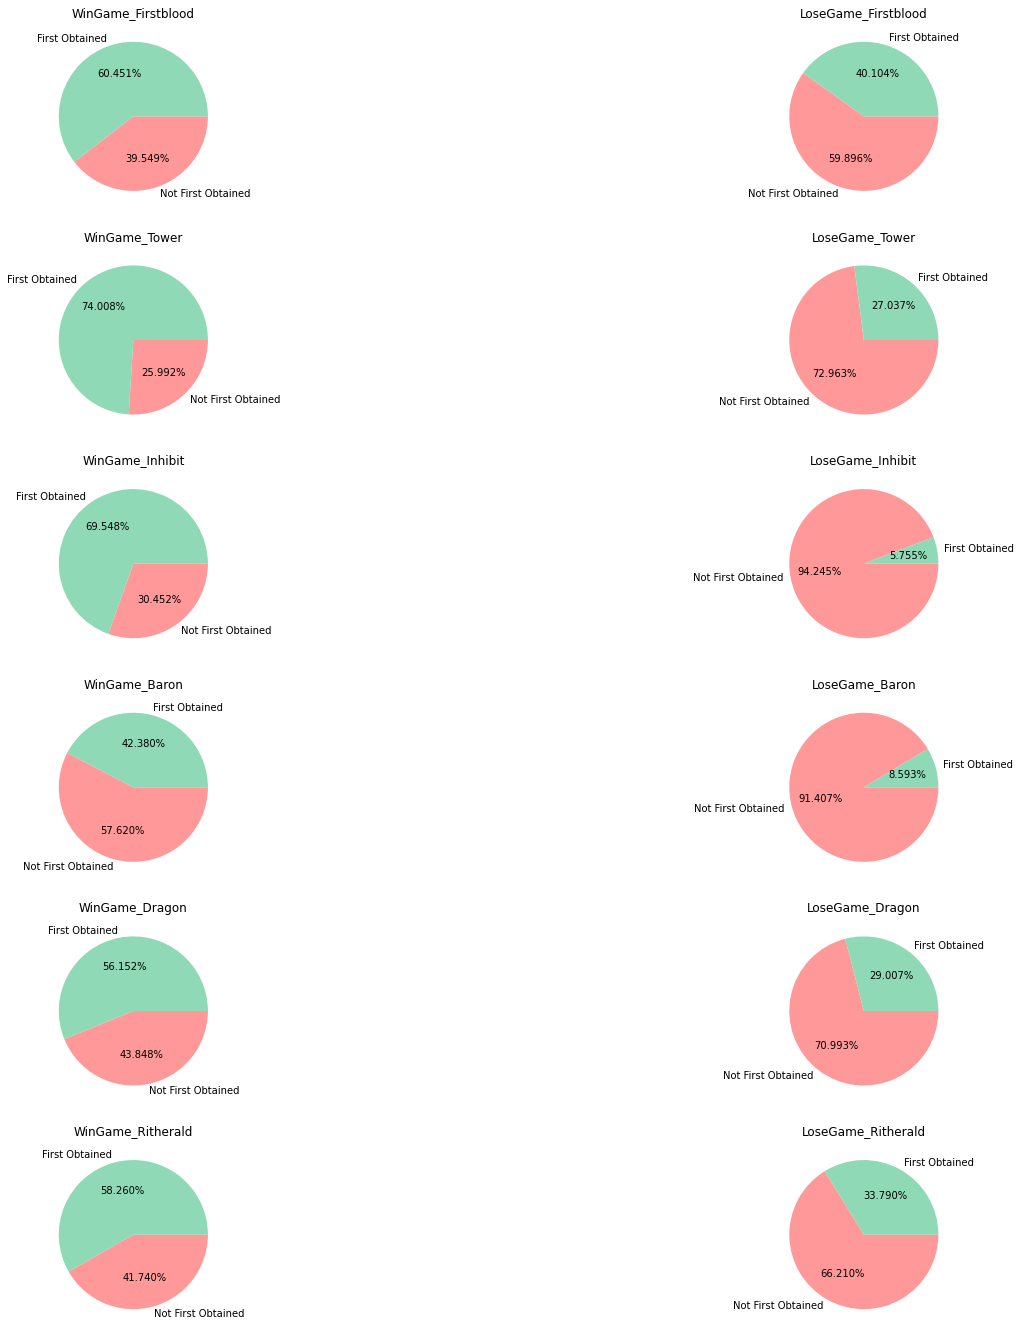

In [39]:
# 데이터 시각화

# 총 17만개의 게임경기 데이터
colors = ['#FF9999', '#8fd9b6']
fig, axes = plt.subplots(6,2,figsize=(24,24))

num = 0
for i in range(6):
    for j in range(2):
        axes[i][j].pie((a[0][num],a[1][num]),labels=['Not First Obtained','First Obtained'],autopct='%.3f%%', startangle=360, counterclock=False, colors = colors)
        num += 1

axes[0][0].set_title("WinGame_Firstblood")
axes[0][1].set_title("LoseGame_Firstblood")        
axes[1][0].set_title("WinGame_Tower")
axes[1][1].set_title("LoseGame_Tower")    
axes[2][0].set_title("WinGame_Inhibit")
axes[2][1].set_title("LoseGame_Inhibit")    
axes[3][0].set_title("WinGame_Baron")
axes[3][1].set_title("LoseGame_Baron")  
axes[4][0].set_title("WinGame_Dragon")
axes[4][1].set_title("LoseGame_Dragon")    
axes[5][0].set_title("WinGame_Ritherald")
axes[5][1].set_title("LoseGame_Ritherald")    

plt.show()

Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



정확도 :  0.8648150249659555
[[    0     1     0]
 [    0 14617  2202]
 [    0  2562 15866]]


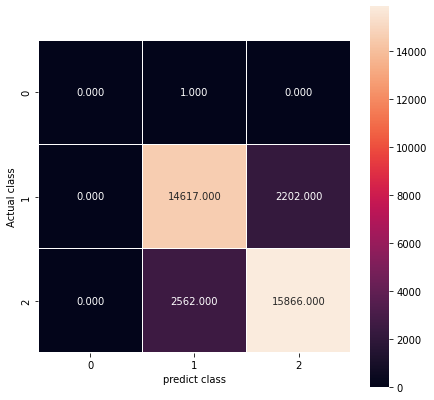

In [40]:
train_x = np.array(pd.DataFrame(add_data, columns=['firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald',
                                                          'towerKills','inhibitorKills','baronKills','dragonKills','riftHeraldKills']))  

train_y = np.array(pd.DataFrame(add_data, columns=['win'])) 

train_x = train_x.astype(np.int64)
train_y = train_y.astype(np.int64)


X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=0.20, random_state=36)

X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=0.20, random_state=46)

clf = LogisticRegression(random_state = 46)
clf.fit(X_train, Y_train)

y_pred = clf.predict(X_test)

accuracy_score(Y_test,y_pred)
print("정확도 : ",accuracy_score(Y_test,y_pred))

conf_mat = confusion_matrix(Y_test,y_pred)
print(confusion_matrix(Y_test,y_pred))

plt.figure(figsize=(7,7))
sns.heatmap(conf_mat, annot = True, fmt=".3f", linewidths=.5,square=True)
plt.ylabel("Actual class")
plt.xlabel("predict class")
plt.show()